## Importing libraries and setup

In [12]:
!pip install torchsummary 

In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import seaborn as sn
import pandas as pd
from torchsummary import summary

In [14]:
print(torchvision.__version__)

0.12.0


## Data Preprocessing and Augmentation

In [15]:
BATCH_SIZE = 8

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/iitm-edutech-electrical/Electrical - Dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
              for x in ['train', 'test']
              }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,3))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pausing so that plots are updated

training data - samples


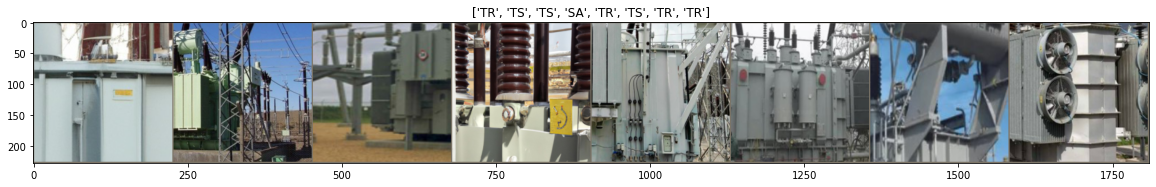

In [18]:
print("training data - samples")
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

test data - samples


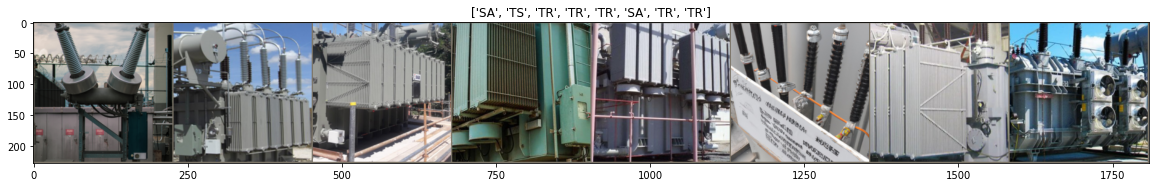

In [19]:
print("test data - samples")
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creating and Training the model 

In [20]:
def train_model(model, criterion, optimizer, scheduler, history, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_history = {"loss":[], "acc":[]}
    test_history = {"loss":[], "acc":[]}
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
#             if phase == 'test':
#                 scheduler.step(epoch_loss)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_history['acc'].append(epoch_acc)
                train_history['loss'].append(epoch_loss)
            else:
                test_history['acc'].append(epoch_acc)
                test_history['loss'].append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    history["test"] = test_history
    history["train"] = train_history
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print(f'predicted: {class_names[preds[j]]}')
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('tight')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                print('---------------------------------')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

We are using ResNet18 pre-trained on imagenet along with our own classification layer. We are using SGD as our optimizer. 

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs - 
# NOT BEING USED AS CONSTANT LR PRODUCED HIGHER PERFORMANCE
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min')


summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [23]:
history = {}
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, history, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0135 Acc: 0.4948
test Loss: 0.6082 Acc: 0.7037
Epoch 1/49
----------
train Loss: 0.7418 Acc: 0.6875
test Loss: 0.6322 Acc: 0.6852
Epoch 2/49
----------
train Loss: 0.5553 Acc: 0.7812
test Loss: 0.4696 Acc: 0.7593
Epoch 3/49
----------
train Loss: 0.4857 Acc: 0.8229
test Loss: 0.4024 Acc: 0.8333
Epoch 4/49
----------
train Loss: 0.4450 Acc: 0.7917
test Loss: 0.4039 Acc: 0.8333
Epoch 5/49
----------
train Loss: 0.5071 Acc: 0.7969
test Loss: 0.4085 Acc: 0.8148
Epoch 6/49
----------
train Loss: 0.3817 Acc: 0.8698
test Loss: 0.3516 Acc: 0.8333
Epoch 7/49
----------
train Loss: 0.3905 Acc: 0.8438
test Loss: 0.3938 Acc: 0.8148
Epoch 8/49
----------
train Loss: 0.3470 Acc: 0.8958
test Loss: 0.3231 Acc: 0.8704
Epoch 9/49
----------
train Loss: 0.3949 Acc: 0.8594
test Loss: 0.3809 Acc: 0.8333
Epoch 10/49
----------
train Loss: 0.3293 Acc: 0.8802
test Loss: 0.7170 Acc: 0.7407
Epoch 11/49
----------
train Loss: 0.4108 Acc: 0.8750
test Loss: 0.4232 Acc: 0.8148
Ep

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


predicted: TS


<Figure size 432x288 with 0 Axes>

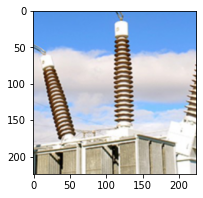

---------------------------------
predicted: TR


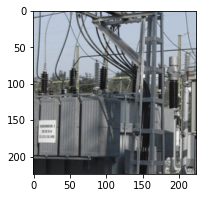

---------------------------------
predicted: TS


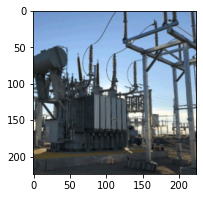

---------------------------------
predicted: TS


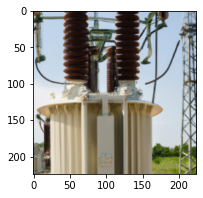

---------------------------------
predicted: TR


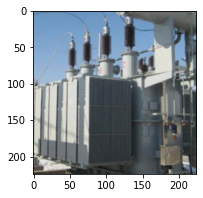

---------------------------------
predicted: TS


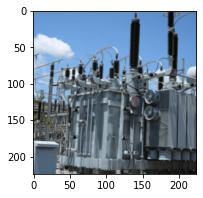

---------------------------------


In [30]:
visualize_model(model_ft)

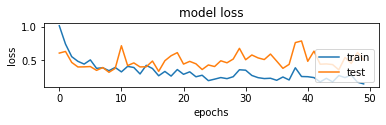

In [45]:
plt.subplot(3,1,1)
plt.plot(history["train"]["loss"], label='train loss')
plt.plot(history["test"]["loss"], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend(['train', 'test'], loc='lower right')
plt.savefig('loss.png')
plt.show()


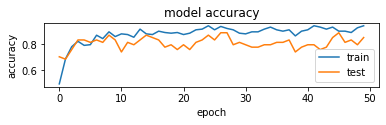

In [44]:
plt.subplot(3,1,1)
plt.plot(torch.Tensor(history['train']['acc']).cpu(), label='train accuracy')
plt.plot(torch.Tensor(history['test']['acc']).cpu(), label='train accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.savefig('accuracy.png')

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


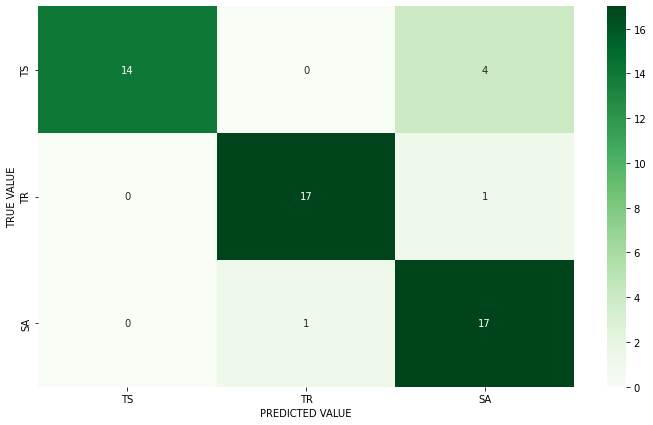

In [42]:
y_pred = []
y_true = []

# iterate over test data
for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('TS', 'TR', 'SA')

# print('Confusion Matrix:')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap="Greens", annot=True)
plt.ylabel('TRUE VALUE')
plt.xlabel('PREDICTED VALUE')
plt.savefig('output.png')

In [34]:
report = classification_report(
    y_true, 
    y_pred, 
    target_names=classes
)
print(report)

              precision    recall  f1-score   support

          TS       1.00      0.78      0.88        18
          TR       0.94      0.94      0.94        18
          SA       0.77      0.94      0.85        18

    accuracy                           0.89        54
   macro avg       0.91      0.89      0.89        54
weighted avg       0.91      0.89      0.89        54



In [35]:
kappa = cohen_kappa_score(y_pred, y_true, weights=None, sample_weight=None)
print(f"The Kappa Score is {kappa}" )

The Kappa Score is 0.8333333333333334
